# Bloch-Redfield Solver: Time dependent operators

Authors: C. Staufenbiel, 2022

following the instructions in the [Bloch-Redfield documentation](https://qutip.readthedocs.io/en/latest/guide/dynamics/dynamics-bloch-redfield.html?#time-dependent-bloch-redfield-dynamics).

### Introduction
This notebook introduces the usage of time-dependent operators in the Bloch-Redfield solver, which is also described in the [corresponding documentation](https://qutip.readthedocs.io/en/latest/guide/dynamics/dynamics-bloch-redfield.html?#time-dependent-bloch-redfield-dynamics).

We will discuss time-dependent Hamiltonians and time-dependent dissipations.

### Imports

In [1]:
import numpy as np
from qutip import about, basis, brmesolve, destroy, plot_expectation_values

%matplotlib inline

For our small example, we setup a system with `N` states and the number operator as Hamiltonian. We can observe that for the constant Hamiltonian and no given `a_ops` the expectation value $\langle n \rangle $ is a constant.

In [2]:
# num modes
N = 2
# Hamiltonian
a = destroy(N)
H = a.dag() * a

# initial state
psi0 = basis(N, N - 1)

# times for simulation
times = np.linspace(0, 10, 100)

# solve using brmesolve
result_const = brmesolve(H, psi0, times, e_ops=[a.dag() * a])

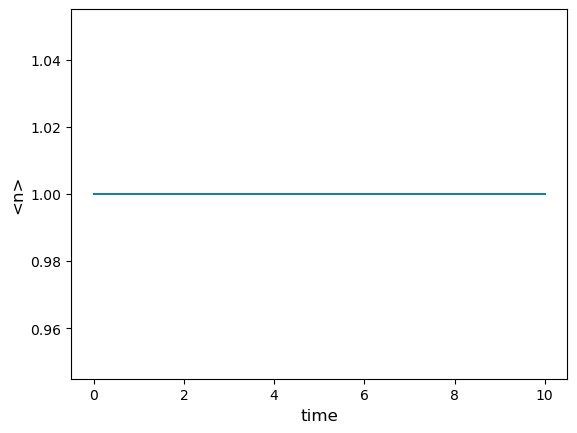

In [3]:
plot_expectation_values(result_const, ylabels=["<n>"]);

Next we define a string, which describes some time-dependence. We can use functions that are supported by the Cython implementation. A list of all supported functions can be found in the  [docs](https://qutip.readthedocs.io/en/latest/guide/dynamics/dynamics-time.html#time). For example, supported functions are `sin` or `exp`. The time variable is denoted by `t`.

In [4]:
time_dependence = "sin(t)"

### Time-dependent Hamiltonian

As a first example, we define a time-dependent Hamiltonian (as described [here](https://qutip.readthedocs.io/en/latest/guide/dynamics/dynamics-time.html)). 

$$ H = \hat{n} + sin(t) \hat{x} $$

Again, we can solve the dynamics using `brmesolve()`.

/home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip/core/coefficient.py:423: UserWarning: `cython`, `setuptools` and `filelock` are required for compilation of string coefficents. Falling back on `eval`.
  warnings.warn(


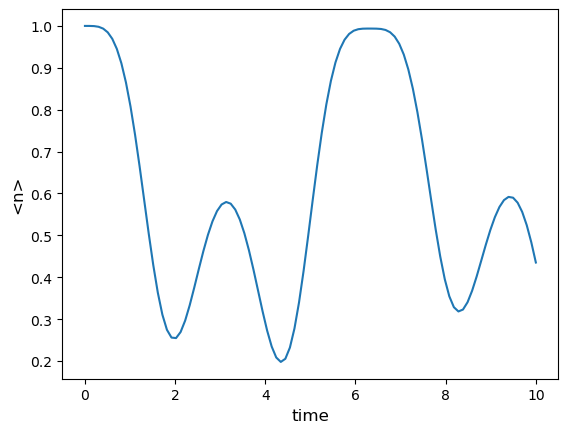

In [5]:
H_t = [H, [a + a.dag(), time_dependence]]
result_brme = brmesolve(H_t, psi0, times, e_ops=[a.dag() * a])
plot_expectation_values(result_brme, ylabels=["<n>"]);

### Time-dependent dissipation

Above we did not use the noise-power-spectrum, which the Bloch-Redfield solver is mainly used for. This spectrum is passed in the argument `a_ops`. We can also add a string-based time dependence to `a_ops` and thereby make the dissipation itself time-dependent. 

Here we will define a a noice power spectrum of the form:

$$ J(\omega, t) = \kappa * e^{-t} \quad \text{for} \; \omega \geq 0$$

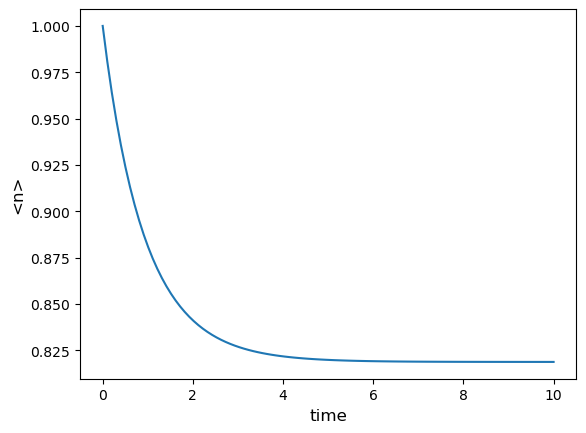

In [6]:
# setup dissipation
kappa = 0.2
a_ops = [
    ([a+a.dag(), f'sqrt({kappa}*exp(-t))'], '(w>=0)')
]
# solve
result_brme_aops = brmesolve(H, psi0, times, a_ops, e_ops=[a.dag() * a])

plot_expectation_values([result_brme_aops], ylabels=["<n>"]);

The coupling to the bath is sometimes described by operators of the form

$$ A = f(t)a + f(t)^* a^\dagger $$

To add such a coupling to `brmesolve` we can pass tuple in the `a_ops` argument. For example if we have $f(t) = e^{i * t}$ we can define the coupling of operator $A$ with strength $\kappa$ by the following `a_ops`. Note that the second function needs to be the complex conjugate of the first function and the second operator the hermitian conjugate of the first operator.

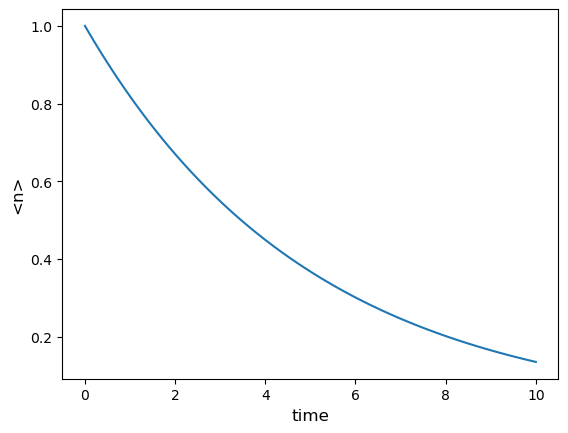

In [7]:
a_ops = [([[a, 'exp(1j*t)'], [a.dag(), 'exp(-1j*t)']],
          f'{kappa} * (w >= 0)')]

# solve using brmesolve and plot expecation
result_brme_aops_sum = brmesolve(H, psi0, times, a_ops, e_ops=[a.dag() * a])
plot_expectation_values([result_brme_aops_sum], ylabels=["<n>"]);

### About

In [8]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.3.0.dev0+6e4b53d
Numpy Version:      2.3.5
Scipy Version:      1.16.3
Cython Version:     3.2.2
Matplotlib Version: 3.10.8
Python Version:     3.12.0
Number of CPUs:     4
BLAS Info:          blas
INTEL MKL Ext:      None
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip

Installed QuTiP family packages
-------------------------------

qutip-qtrl: 

qutip-jax: 0.1.1.dev6
qutip-qip: 0.5.0.dev0+81a92b9

Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`


### Testing

In [9]:
assert np.allclose(result_const.expect[0], 1.0)

# compare result from brme with a_ops to analytic solution
analytic_aops = (N - 1) * np.exp(-kappa * (1.0 - np.exp(-times)))
assert np.allclose(result_brme_aops.expect[0], analytic_aops)

assert np.all(np.diff(result_brme_aops_sum.expect[0]) <= 0.0)